In [23]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline

In [24]:
# Read in data from CSV into a Spark data frame
#sc = SparkContext()
sqlContext = SQLContext(sc)

In [25]:
# FEATURES_COL = ['_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10',\
#                 '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c18', '_c19', '_c20',\
#                 '_c21', '_c22', '_c23', '_c24', '_c25', '_c26', '_c27', '_c28', '_c29', '_c30',\
#                 '_c31', '_c32', '_c33', '_c34', '_c35', '_c36', '_c37', '_c38', '_c39', '_c40',\
#                 '_c41', '_c42', '_c43', '_c44', '_c45', '_c46', '_c47', '_c48', '_c49', '_c50'
#                ]
FEATURES_COL = ['_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10',\
                '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c18', '_c19', '_c20'
               ]
path = 'res_comment_svd.csv'

df = sqlContext.read.csv(path, header=False) # requires spark 2.0
df.show()
df.count()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 _c0|                 _c1|                 _c2|                 _c3|                 _c4|                 _c5|                 _c6|                 _c7|                 _c8|                 _c9|                _c10|                _c11|                _c12|                _c13|                _c14|                _c15|                _c16|                _c17|                _c18|                _c19|                _c20|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------

23386

In [26]:
# Drop the null values

df = df.na.drop()
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 _c0|                 _c1|                 _c2|                 _c3|                 _c4|                 _c5|                 _c6|                 _c7|                 _c8|                 _c9|                _c10|                _c11|                _c12|                _c13|                _c14|                _c15|                _c16|                _c17|                _c18|                _c19|                _c20|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------

In [5]:
# # Convert all data columns to float

# df = df.select(*(df[c].cast("float").alias(c) for c in df.columns[:]))
# df.show()

In [27]:
# Convert all data columns to float

for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+--------------------+-----------+------------+-----------+------------+-------------+------------+-----------+------------+------------+------------+------------+-----------+------------+------------+-------------+------------+------------+------------+------------+------------+
|                 _c0|        _c1|         _c2|        _c3|         _c4|          _c5|         _c6|        _c7|         _c8|         _c9|        _c10|        _c11|       _c12|        _c13|        _c14|         _c15|        _c16|        _c17|        _c18|        _c19|        _c20|
+--------------------+-----------+------------+-----------+------------+-------------+------------+-----------+------------+------------+------------+------------+-----------+------------+------------+-------------+------------+------------+------------+------------+------------+
|5c7727879dc6d68ae...| -0.5270616|  0.15366766|-0.46544477|   0.6265333| -0.005757016| -0.48616204| -0.1726552|   0.3728641| -0.59226227| -0.16619635|  0.428

In [28]:
# Create a features column to be used in the clustering

vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('_c0', 'features')
df_kmeans.show()

+--------------------+--------------------+
|                 _c0|            features|
+--------------------+--------------------+
|5c7727879dc6d68ae...|[-0.5270615816116...|
|5c7727879dc6d68ae...|[-0.7532513141632...|
|5c7727879dc6d68ae...|[-0.3682641088962...|
|5c7727999dc6d68ae...|[0.02389703318476...|
|5c77279a9dc6d68ae...|[0.51692122220993...|
|5c77279a9dc6d68ae...|[-0.2399544417858...|
|5c77279b9dc6d68ae...|[-0.3933383822441...|
|5c77279e9dc6d68ae...|[0.47282138466835...|
|5c77279e9dc6d68ae...|[0.31593006849288...|
|5c77279f9dc6d68ae...|[0.36733070015907...|
|5c77279f9dc6d68ae...|[-0.6466968059539...|
|5c7727a09dc6d68ae...|[-0.1037359535694...|
|5c7727a19dc6d68ae...|[-0.1624595969915...|
|5c7727a19dc6d68ae...|[-0.2467780858278...|
|5c7727a39dc6d68ae...|[-0.2104313969612...|
|5c7727a39dc6d68ae...|[-0.5748968124389...|
|5c7727ae9dc6d68ae...|[0.46044507622718...|
|5c7727af9dc6d68ae...|[0.51992756128311...|
|5c7727b59dc6d68ae...|[-0.6273331642150...|
|5c7727b79dc6d68ae...|[-0.487938

In [29]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setInitMode("k-means||").setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later
    print("k=", k, " cost=", cost[k])

k= 2  cost= 26827.193970853044
k= 3  cost= 23024.068018120328
k= 4  cost= 20736.847725563977
k= 5  cost= 19371.975931942903
k= 6  cost= 18018.62298589943
k= 7  cost= 17123.72112732913
k= 8  cost= 16323.363864844228
k= 9  cost= 15926.35293449496
k= 10  cost= 15198.534934380954
k= 11  cost= 14756.95474369269
k= 12  cost= 14400.091504978092
k= 13  cost= 14133.064756331469
k= 14  cost= 13609.724867621038
k= 15  cost= 13440.598013872965
k= 16  cost= 13079.03890623632
k= 17  cost= 12747.822635677254
k= 18  cost= 12754.656765596865
k= 19  cost= 12506.974545208479


Text(0, 0.5, 'cost')

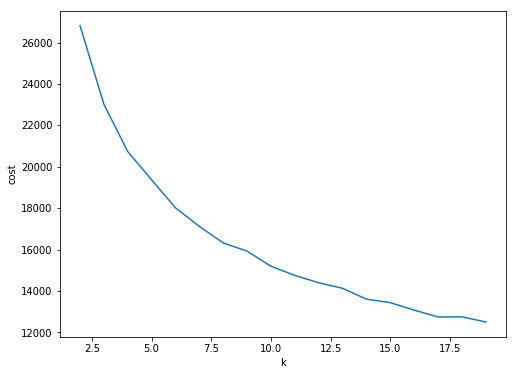

In [30]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [31]:
# Train the machine learning model

k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 0.26920389  0.25390603 -0.34802534  0.45326857 -0.11628348 -0.35223173
 -0.11141342  0.12555414 -0.15955262 -0.09140689  0.06895882 -0.07699783
  0.10392966 -0.22567549 -0.07190293  0.07188851  0.19489463 -0.2834516
 -0.05634394  0.14044971]
[ 0.23878712 -0.07055698  0.28099605 -0.38487501 -0.06237647  0.22375093
  0.23006692 -0.15585014  0.21787879 -0.08225011 -0.19286131 -0.14437867
  0.03498135 -0.16076523  0.01156505  0.16443436 -0.25061963  0.35513459
 -0.08526927 -0.27973059]
[ 0.28865269  0.20003507  0.03626167 -0.13309308 -0.06878978  0.08436896
  0.18509832 -0.29169534  0.38162529 -0.10130519 -0.28919172 -0.04589846
 -0.02848615 -0.25789102 -0.12684436  0.0520326   0.20523127 -0.25659979
  0.00457463  0.14553445]
[-0.40996824  0.03048799  0.29921748 -0.40509701 -0.02127494  0.24088439
  0.2688278  -0.12171357  0.16365712 -0.0443472  -0.16205712  0.51515855
  0.03707751 -0.06140488 -0.34264461 -0.10908571  0.12528224 -0.06802107
 -0.11470569 -0.02406357]
[-0

In [32]:
# Assign clusters to events

#transformed = model.transform(df_kmeans).select('_c0', 'prediction')
transformed = model.transform(df_kmeans)
transformed.coalesce(1).write.parquet('rest_pred.parquet')
rows = transformed.collect()
print(rows[:3])

[Row(_c0='5c7727879dc6d68ae78b46b8', features=DenseVector([-0.5271, 0.1537, -0.4654, 0.6265, -0.0058, -0.4862, -0.1727, 0.3729, -0.5923, -0.1662, 0.4288, 0.4738, 0.3886, 0.1315, -0.1401, -0.0508, 0.5698, -0.4864, -0.4507, -0.0333]), prediction=4), Row(_c0='5c7727879dc6d68ae78b46b9', features=DenseVector([-0.7533, 0.0688, -0.5546, 0.7784, -0.0592, -0.4995, -0.2326, -0.0119, 0.1914, -0.0749, -0.0969, 0.4695, -0.1154, 0.2587, -0.0825, -0.0743, 0.0579, -0.1552, -0.1616, 0.0876]), prediction=5), Row(_c0='5c7727879dc6d68ae78b46bb', features=DenseVector([-0.3683, 0.2304, -0.5279, 0.673, -0.0, -0.3937, -0.3008, 0.278, -0.2505, -0.0274, 0.1782, 0.4198, -0.0095, 0.0139, -0.2523, -0.2136, 0.372, -0.5246, 0.0845, 0.4325]), prediction=4)]


In [45]:
transformed2 = sqlContext.read.parquet('rest_pred.parquet')
transformed2.show()
rows = transformed.collect()
print(rows[:3])

+--------------------+--------------------+----------+
|                 _c0|            features|prediction|
+--------------------+--------------------+----------+
|5c7727879dc6d68ae...|[-0.5270615816116...|         4|
|5c7727879dc6d68ae...|[-0.7532513141632...|         5|
|5c7727879dc6d68ae...|[-0.3682641088962...|         4|
|5c7727999dc6d68ae...|[0.02389703318476...|         2|
|5c77279a9dc6d68ae...|[0.51692122220993...|         7|
|5c77279a9dc6d68ae...|[-0.2399544417858...|         7|
|5c77279b9dc6d68ae...|[-0.3933383822441...|         3|
|5c77279e9dc6d68ae...|[0.47282138466835...|         8|
|5c77279e9dc6d68ae...|[0.31593006849288...|         0|
|5c77279f9dc6d68ae...|[0.36733070015907...|         6|
|5c77279f9dc6d68ae...|[-0.6466968059539...|         3|
|5c7727a09dc6d68ae...|[-0.1037359535694...|         4|
|5c7727a19dc6d68ae...|[-0.1624595969915...|         3|
|5c7727a19dc6d68ae...|[-0.2467780858278...|         3|
|5c7727a39dc6d68ae...|[-0.2104313969612...|         9|
|5c7727a39

In [34]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(transformed)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.24306527580522677


In [35]:
from pyspark.ml.clustering import KMeansModel
model_path = "/home/vovo/PycharmProjects/etl/restaurant_kmeans.model"
model.save(model_path)

In [36]:
model2 = KMeansModel.load(model_path)

In [37]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+--------------------+--------------------+----------+
|                 _c0|            features|prediction|
+--------------------+--------------------+----------+
|5c7727879dc6d68ae...|[-0.5270615816116...|         4|
|5c7727879dc6d68ae...|[-0.7532513141632...|         5|
|5c7727879dc6d68ae...|[-0.3682641088962...|         4|
|5c7727999dc6d68ae...|[0.02389703318476...|         2|
|5c77279a9dc6d68ae...|[0.51692122220993...|         7|
|5c77279a9dc6d68ae...|[-0.2399544417858...|         7|
|5c77279b9dc6d68ae...|[-0.3933383822441...|         3|
|5c77279e9dc6d68ae...|[0.47282138466835...|         8|
|5c77279e9dc6d68ae...|[0.31593006849288...|         0|
|5c77279f9dc6d68ae...|[0.36733070015907...|         6|
|5c77279f9dc6d68ae...|[-0.6466968059539...|         3|
|5c7727a09dc6d68ae...|[-0.1037359535694...|         4|
|5c7727a19dc6d68ae...|[-0.1624595969915...|         3|
|5c7727a19dc6d68ae...|[-0.2467780858278...|         3|
|5c7727a39dc6d68ae...|[-0.2104313969612...|         9|
|5c7727a39

In [38]:
df_pred = df_pred.withColumnRenamed("_c0", "pred_id")
df_pred.show()

+--------------------+--------------------+----------+
|             pred_id|            features|prediction|
+--------------------+--------------------+----------+
|5c7727879dc6d68ae...|[-0.5270615816116...|         4|
|5c7727879dc6d68ae...|[-0.7532513141632...|         5|
|5c7727879dc6d68ae...|[-0.3682641088962...|         4|
|5c7727999dc6d68ae...|[0.02389703318476...|         2|
|5c77279a9dc6d68ae...|[0.51692122220993...|         7|
|5c77279a9dc6d68ae...|[-0.2399544417858...|         7|
|5c77279b9dc6d68ae...|[-0.3933383822441...|         3|
|5c77279e9dc6d68ae...|[0.47282138466835...|         8|
|5c77279e9dc6d68ae...|[0.31593006849288...|         0|
|5c77279f9dc6d68ae...|[0.36733070015907...|         6|
|5c77279f9dc6d68ae...|[-0.6466968059539...|         3|
|5c7727a09dc6d68ae...|[-0.1037359535694...|         4|
|5c7727a19dc6d68ae...|[-0.1624595969915...|         3|
|5c7727a19dc6d68ae...|[-0.2467780858278...|         3|
|5c7727a39dc6d68ae...|[-0.2104313969612...|         9|
|5c7727a39

In [39]:
# Join the prediction with the original data

df_pred = df_pred.join(df, df_pred.pred_id == df._c0, "inner")
df_pred.show()

+--------------------+--------------------+----------+--------------------+-----------+------------+-----------+------------+-------------+------------+-----------+------------+------------+------------+------------+-----------+------------+------------+-------------+------------+------------+------------+------------+------------+
|             pred_id|            features|prediction|                 _c0|        _c1|         _c2|        _c3|         _c4|          _c5|         _c6|        _c7|         _c8|         _c9|        _c10|        _c11|       _c12|        _c13|        _c14|         _c15|        _c16|        _c17|        _c18|        _c19|        _c20|
+--------------------+--------------------+----------+--------------------+-----------+------------+-----------+------------+-------------+------------+-----------+------------+------------+------------+------------+-----------+------------+------------+-------------+------------+------------+------------+------------+------------

In [40]:
# df_pred.printSchema()
df_pred.filter(df_pred["prediction"] == 4).count()
df_pred.printSchema()

root
 |-- pred_id: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: long (nullable = true)
 |-- _c0: string (nullable = true)
 |-- _c1: float (nullable = true)
 |-- _c2: float (nullable = true)
 |-- _c3: float (nullable = true)
 |-- _c4: float (nullable = true)
 |-- _c5: float (nullable = true)
 |-- _c6: float (nullable = true)
 |-- _c7: float (nullable = true)
 |-- _c8: float (nullable = true)
 |-- _c9: float (nullable = true)
 |-- _c10: float (nullable = true)
 |-- _c11: float (nullable = true)
 |-- _c12: float (nullable = true)
 |-- _c13: float (nullable = true)
 |-- _c14: float (nullable = true)
 |-- _c15: float (nullable = true)
 |-- _c16: float (nullable = true)
 |-- _c17: float (nullable = true)
 |-- _c18: float (nullable = true)
 |-- _c19: float (nullable = true)
 |-- _c20: float (nullable = true)



In [41]:
df_pred = df_pred.select("pred_id", "prediction", "_c0", "_c1", "_c2", "_c3", "_c4", "_c5",\
                                                  "_c6", "_c7", "_c8", "_c9", "_c10", "_c11",\
                                                  "_c12", "_c13", "_c14", "_c15", "_c16", "_c17",\
                                                  "_c18", "_c19", "_c20")

df_pred.coalesce(1).write.csv('res_pred.csv')

In [42]:
path = 'mongoshop.csv'

df_shop = sqlContext.read.csv(path, header=True) # requires spark 2.0
df_shop.show()
df_shop.count()

+--------------------------------------+--------------------+----------+----------------------+----------------+----------------+-------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+--------+----------+--------------+--------------------+-------------------+-------------------------------------+--------------------+-----+----------+----+------------+-------------------+----------+----------+------+------+
|                                   _id|        addrLocality|addrRegion|               address|bizhour.0.週一.0|bizhour.1.週二.0|   bizhour.1.週二.1|bizhour.2.週三.0|bizhour.2.週三.1|bizhour.3.週四.0|bizhour.3.週四.1|bizhour.4.週五.0|bizhour.4.週五.1|bizhour.5.週六.0|bizhour.5.週六.1|bizhour.6.週日.0|bizhour.6.週日.1|category|categoryID|classification|             comment|           datetime|                          description|                href|level|      name|page|    

42356

In [43]:
df_shop = df_shop.join(df_pred, df_shop._id == df_pred.pred_id, "inner")

df_shop.show(5)
df_shop.count()

+--------------------+------------+----------+-------------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+--------+----------+--------------+--------------------+-------------------+------------------------------------+--------------------+-----+--------------------------+----+------------+-------------------+----------+----------+------+------+--------------------+----------+--------------------+-----------+----------+-----------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+----------+------------+-----------+-----------+------------+----------+-----------+-----------+------------+
|                 _id|addrLocality|addrRegion|            address|bizhour.0.週一.0|bizhour.1.週二.0|bizhour.1.週二.1|bizhour.2.週三.0|bizhour.2.週三.1|bizhour.3.週四.0|bizhour.3.週四.1|bizho

23386

In [44]:
# df_pred.printSchema()

df_shop.filter(df_shop["prediction"] == 0).select("name", "priceRange", "rating", "description").show(50)
df_shop.filter(df_shop["prediction"] == 0).count()
# df_shop.filter(df_shop["name"] == "亓家蒸餃").show()

+----------------------------------+----------+------+-------------------------------------+
|                              name|priceRange|rating|                          description|
+----------------------------------+----------+------+-------------------------------------+
|                      杭州小籠湯包|       233|    40| "杭州小籠湯包是一個有台北美食、湯...|
|                              null|      null|  null|                   與國賓戲院比鄰而居|
|                  吉甜不辣(延吉店)|        68|    45|    "吉甜不辣 (延吉店)是一個有甜不...|
|               京星港式飲茶(PART2)|       407|    40|         "京星港式飲茶 (PART2)是一...|
|                  青青食尚花園會館|       608|    45|青青食尚花園會館座落於人文薈萃的外...|
|                      圓山老崔蒸包|       112|    45| "圓山老崔蒸包是一個有蒸包、早餐、...|
|                        好記擔仔麵|       446|    45| "好記擔仔麵是一個有吃吃喝喝、朋友...|
|                              null|      null|  null| 叁和院 保留台灣溫暖美味，破除台菜...|
|                              null|      null|  null|    1976年政府遷台後，鄧慶瑜先生為...|
|                金泉小吃店賣麵炎仔|       123|    40| 

2813